In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
age_group = pd.read_excel('../data/all_years.xlsx')

In [8]:
age_group.columns

Index(['year', 'facility_id', 'facility_name', 'county', 'address', 'city',
       'zip_code', 'facility_group', 'facility_class',
       'medicare_as_primary_num_of_claims', 'comm_bcbs_as_payer_num_of_claims',
       'other_payer_as_primary_num_of_claims',
       'medicare_claims_inpatient_total_charges',
       'medicare_claims_outpatient_total_charges',
       'medicare_claims_inpatient_total_payment',
       'medicare_claims_outpatient_total_payment',
       'comm_blue_cross_blue_shield_inpatient_total_charges',
       'comm_blue_cross_blue_shield_outpatient_total_charges',
       'comm_blue_cross_blue_shield_inpatient_total_payment',
       'comm_blue_cross_blue_shield_outpatient_total_payment',
       'other_payer_claims_inpatient_total_charges',
       'other_payer_claims_outpatient_total_charges',
       'other_payer_claims_inpatient_total_payment',
       'other_payer_claims_outpatient_total_payment', 'total_uninsured',
       'uninsured_inpatient_charges', 'uninsured_outpatie

In [13]:
# 1. Aggregate counts per location-year-age
agg = age_group.groupby(["county", "year", "age group"], as_index=False)["total_patients"].sum()

# 2. Find the dominant age group per location-year
dominant = (
    agg.sort_values(["county", "facility_name", "year", "total_patients"], ascending=[True, True, True, False])
       .groupby(["county", "facility_name", "year"], as_index=False)
       .first()
)

# 3. Add total patients per location-year (for bubble size)
totals = agg.groupby(["county", "facility_name", "year"], as_index=False)["total_patients"].sum().rename(columns={"patients":"total_patients"})

dominant = dominant.merge(totals, on=["county","facility_name","year"], how="left")




KeyError: 'facility_name'

Rural Facilities by Year
   year  rural_facility_count
0  2021                    66
1  2022                    66
2  2023                    67

Urban Facilities by Year
   year  urban_facility_count
0  2021                    95
1  2022                   100
2  2023                   104


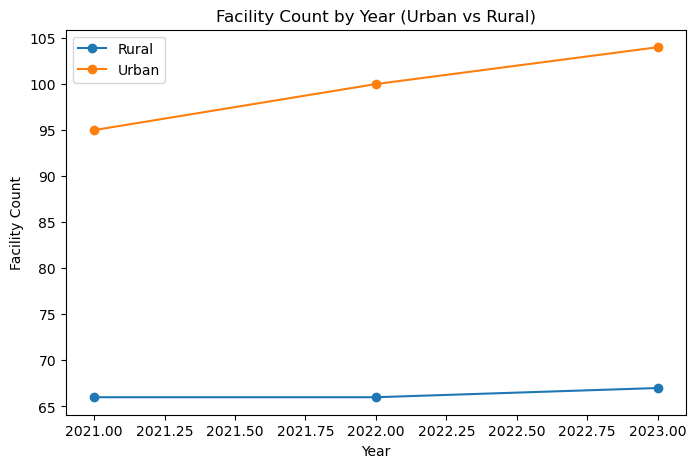

In [19]:


# --- Rural facilities grouped by year ---
rural_facilities = (
    age_group[age_group["Urban Rural"] == "Rural"]
    .groupby("year")["facility_id"]
    .nunique()
    .reset_index(name="rural_facility_count")
)

print("Rural Facilities by Year")
print(rural_facilities)

# --- Urban facilities grouped by year ---
urban_facilities = (
    age_group[age_group["Urban Rural"] == "Urban"]
    .groupby("year")["facility_id"]
    .nunique()
    .reset_index(name="urban_facility_count")
)

print("\nUrban Facilities by Year")
print(urban_facilities)

# --- Plotting separately ---
plt.figure(figsize=(8,5))
plt.plot(rural_facilities["year"], rural_facilities["rural_facility_count"], marker="o", label="Rural")
plt.plot(urban_facilities["year"], urban_facilities["urban_facility_count"], marker="o", label="Urban")
plt.title("Facility Count by Year (Urban vs Rural)")
plt.xlabel("Year")
plt.ylabel("Facility Count")
plt.legend()
plt.show()


In [27]:
lat_lng = pd.read_excel('../data/lat_lng.xlsx')

In [29]:
df_merged = age_group.merge(
    lat_lng[["county", "lat", "lng"]],
    on="county",
    how="left"
)

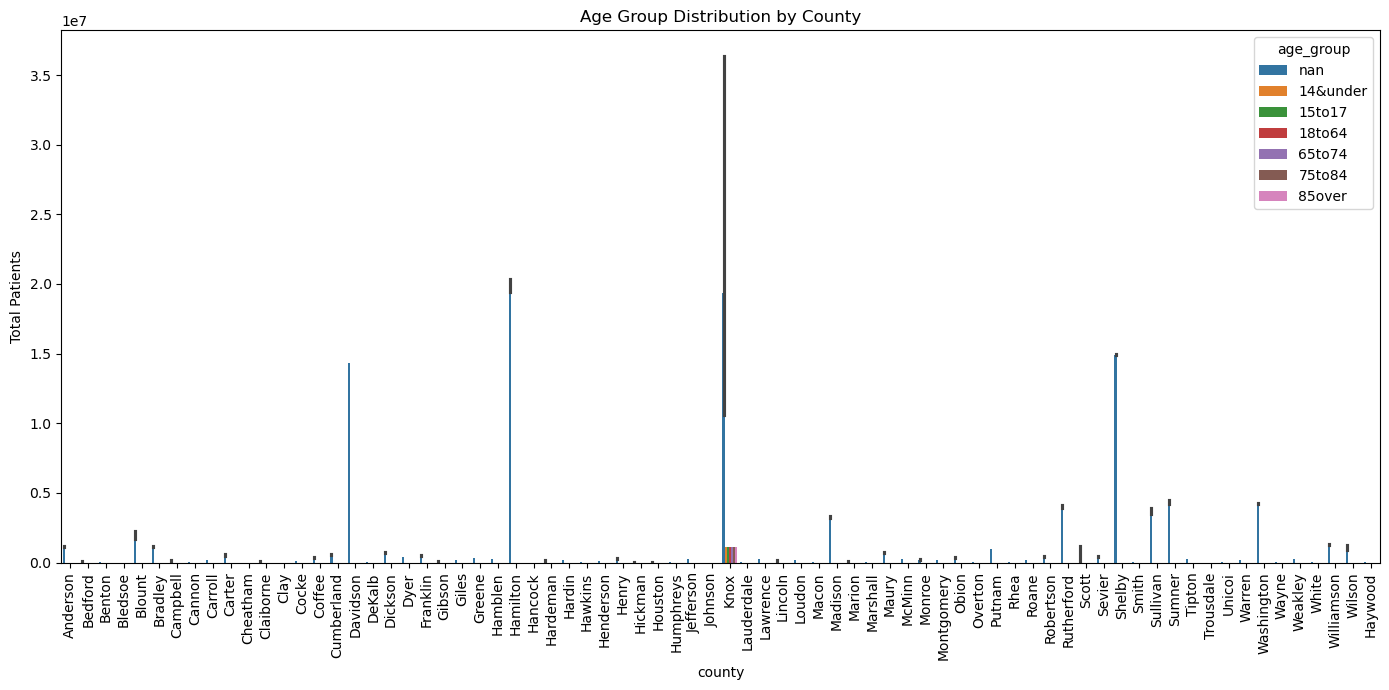

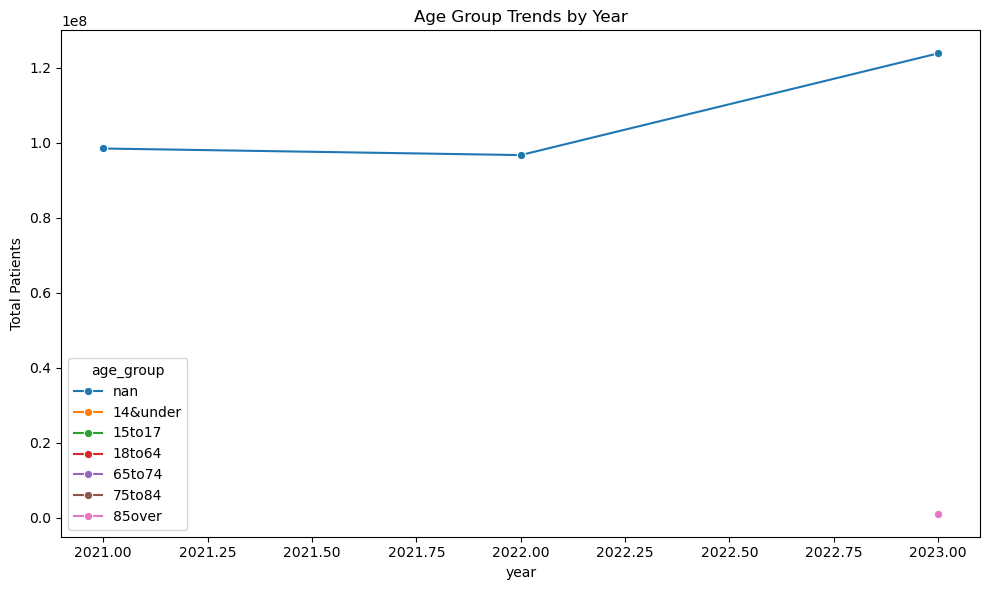

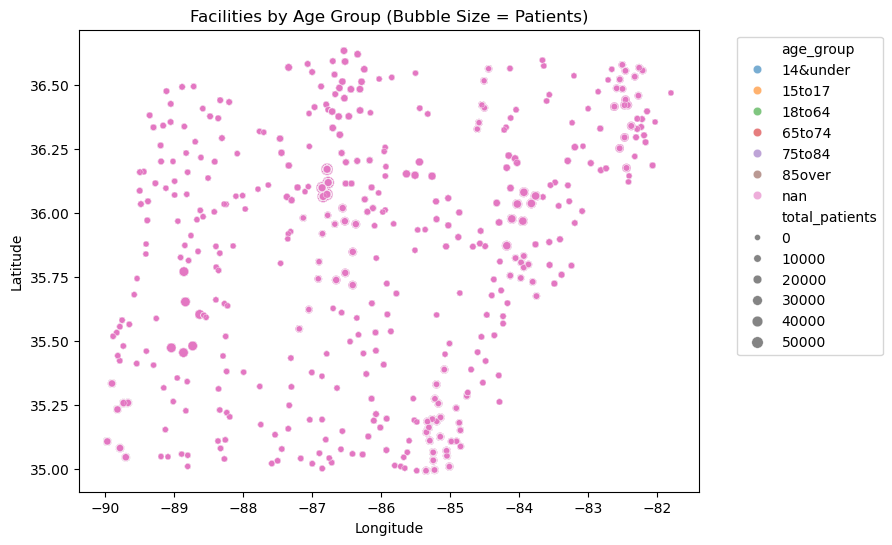

In [33]:

df_merged.rename(columns=lambda x: x.strip().lower().replace(" ", "_"), inplace=True)

# Age group column should be 'age_group'
df_merged['age_group'] = df_merged['age_group'].astype(str)

# --------------------------------
# 2. Aggregate: patients by year, county, age group
# --------------------------------
age_summary = (
    df_merged.groupby(["year", "county", "age_group"], as_index=False)
      .agg({"total_patients": "sum"})
)

# --------------------------------
# 3. Plot: Stacked bar by county/year
# --------------------------------
plt.figure(figsize=(14,7))
sns.barplot(
    data=age_summary,
    x="county",
    y="total_patients",
    hue="age_group"
)
plt.xticks(rotation=90)
plt.ylabel("Total Patients")
plt.title("Age Group Distribution by County")
plt.tight_layout()
plt.show()

# --------------------------------
# 4. Plot: Line trend by year and age group
# --------------------------------
plt.figure(figsize=(10,6))
sns.lineplot(
    data=age_summary.groupby(["year","age_group"], as_index=False).sum(),
    x="year",
    y="total_patients",
    hue="age_group",
    marker="o"
)
plt.title("Age Group Trends by Year")
plt.ylabel("Total Patients")
plt.tight_layout()
plt.show()

# --------------------------------
# 5. Optional: Map-style scatter plot
#    (requires lat/lng columns, if available)
# --------------------------------
if "lat" in df_merged.columns and "lng" in df_merged.columns:
    plt.figure(figsize=(8,6))
    sns.scatterplot(
        data=df_merged,
        x="lng",
        y="lat",
        size="total_patients",
        hue="age_group",
        alpha=0.6
    )
    plt.title("Facilities by Age Group (Bubble Size = Patients)")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
    plt.show()
